### Input: 
Arrest data was exported on April 10th, 2024, with the lates update of the data on January 18, 2024.\
https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc/about_data

### Note:
In this file, it can be used to explain why our focus in in Brooklyn, and the data is solely in 2023.

### Need to Check:
1. null values in merged data
2. within vs. intersects
3. read 2263 from .prj files
4. default 4326, ctx 3857

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from shapely.wkt import loads
import calendar
import warnings
warnings.filterwarnings('ignore')

In [2]:
arrest = pd.read_csv('../../data/raw/NYPD_Arrest_Data__Year_to_Date__20240410.csv'); arrest.head(3)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,261265483,01/03/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,B,49,0,18-24,M,BLACK,1027430,251104,40.855793,-73.843908,POINT (-73.843908 40.855793)
1,261271301,01/03/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,S,120,0,25-44,M,WHITE,962808,174275,40.644996,-74.077263,POINT (-74.077263 40.644996)
2,261336449,01/04/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601001,F,K,61,0,<18,M,BLACK,995118,155708,40.594054,-73.960866,POINT (-73.960866 40.594054)


## Preprocessing

In [3]:
print(arrest.columns)
arrest = arrest[['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column']]

Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')


### Sanity Check

In [4]:
# check if the unqiue values of ARREST_BORO are corresponding to 5 boroughs: K represents Brooklyn based on the data dictionary
print(arrest.ARREST_BORO.unique())

['B' 'S' 'K' 'Q' 'M']


The shape of original data is: (226872, 15)



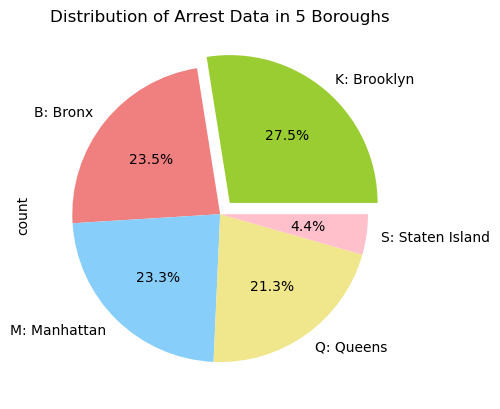


The shape of Brooklyn data is: (62395, 15), which is around 27.5% of original data


In [5]:
print('The shape of original data is:', arrest.shape)
print()
# Plotting the pie chart
plt.figure()
labels = ['K: Brooklyn', 'B: Bronx', 'M: Manhattan', 'Q: Queens', 'S: Staten Island']
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'khaki', 'pink']
explode = (0.1, 0, 0, 0, 0)  
arrest['ARREST_BORO'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=explode, colors=colors, labels=labels)
plt.title('Distribution of Arrest Data in 5 Boroughs')

plt.savefig('../../results/crime_boroughs.png')
plt.show()
print()

arrest_bk = arrest[arrest.ARREST_BORO == 'K']
print(f'The shape of Brooklyn data is: {arrest_bk.shape}, which is around {round(100*(arrest_bk.shape[0]/arrest.shape[0]), 2)}% of original data')

In [6]:
# filter out those with either OFNS_DESC or LAW_CAT_CD are equal to '(null)'
if len(arrest_bk[((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]) > 0:
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to \'(null)\', the shape is:', arrest_bk.shape)
else:
    print('No \"either OFNS_DESC or LAW_CAT_CD equal\"" found!')
# filter out those with both OFNS_DESC and LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with both OFNS_DESC and LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
else:
    print('No \"OFNS_DESC being null and LAW_CAT_CD being null simultaneously\" found!')
# filter out those with either OFNS_DESC or LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) | (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) | (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
else:
    print('No \"OFNS_DESC being null and LAW_CAT_CD being null simultaneously\" found!')
# filter out those LAW_CAT_CD == '9'
if len(arrest_bk[arrest_bk.LAW_CAT_CD == '9']) > 0:
    arrest_bk = arrest_bk[arrest_bk.LAW_CAT_CD != '9']
    print('After fileter out those LAW_CAT_CD == \'9\', the shape is:', arrest_bk.shape)
else:
    print('No LAW_CAT_CD == \'9\' found!')

# combining V and I into one category V/I in column LAW_CAT_CD
arrest_bk['LAW_CAT_CD'] = arrest_bk['LAW_CAT_CD'].replace({'V': 'V/I', 'I': 'V/I'})

After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to '(null)', the shape is: (62390, 15)
No "OFNS_DESC being null and LAW_CAT_CD being null simultaneously" found!
After fileter out those with either OFNS_DESC or LAW_CAT_CD be null values, the shape is: (62190, 15)
After fileter out those LAW_CAT_CD == '9', the shape is: (62178, 15)


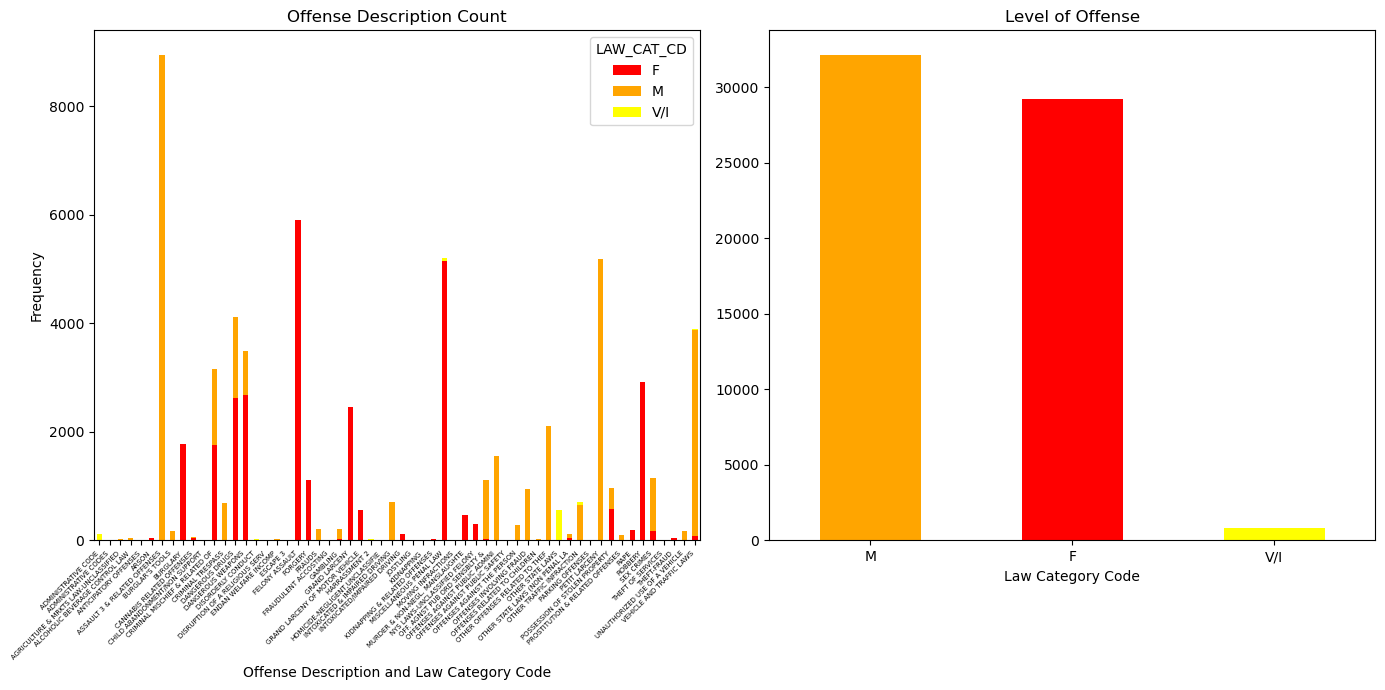

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

grouped = arrest_bk.groupby(['OFNS_DESC','LAW_CAT_CD']).size().sort_values(ascending=False).unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, color=['r','orange','yellow'], ax=axes[0])
axes[0].set_title('Offense Description Count')
axes[0].set_xlabel('Offense Description and Law Category Code')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', which='major', labelsize=5)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

arrest_bk['LAW_CAT_CD'].value_counts().plot(kind='bar', color=['orange','r','yellow'], ax=axes[1])
axes[1].set_title('Level of Offense')
axes[1].set_xlabel('Law Category Code')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()

plt.show()

In order to save the figure:

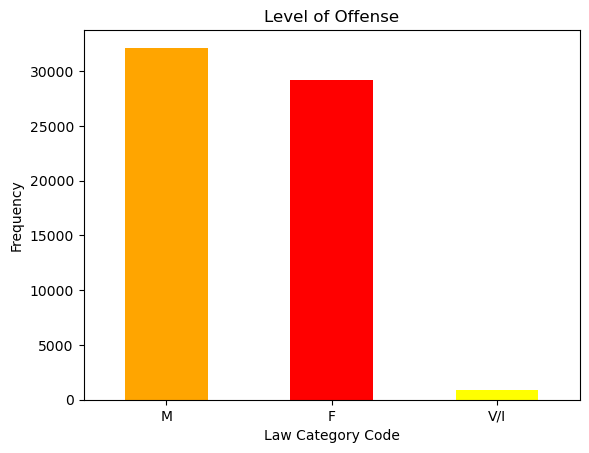

In [8]:
arrest_bk['LAW_CAT_CD'].value_counts().plot(kind='bar', color=['orange', 'red', 'yellow'])

plt.title('Level of Offense')
plt.xlabel('Law Category Code')
plt.ylabel('Frequency')

plt.xticks(rotation=0)

plt.savefig('../../results/level_of_offense.png', bbox_inches='tight')

plt.show()

In [9]:
arrest['ARREST_DATE'] = pd.to_datetime(arrest['ARREST_DATE'])
arrest['ARREST_DATE'].dt.year.unique()

array([2023], dtype=int32)

In [10]:
arrest_bk['ARREST_DATE'] = pd.to_datetime(arrest_bk['ARREST_DATE'])

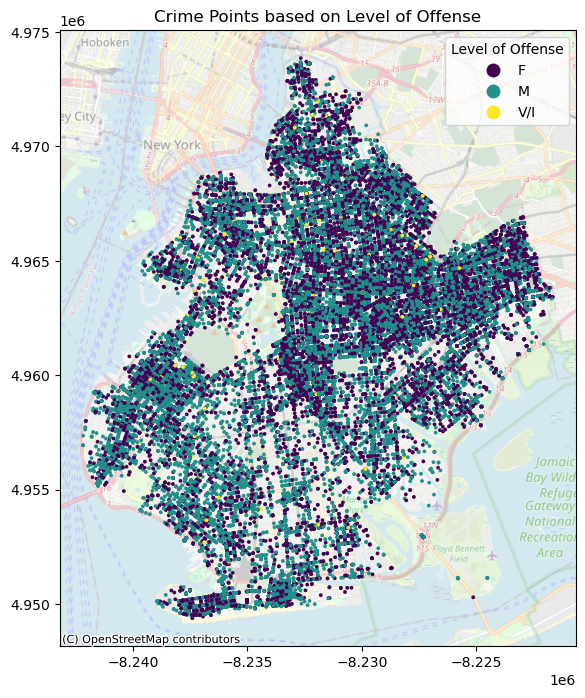

In [11]:
gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857) # in order to match the base map

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='LAW_CAT_CD', legend=True, markersize=3, categorical=True, cmap='viridis', legend_kwds={'title': 'Level of Offense'})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.title('Crime Points based on Level of Offense')
plt.savefig('../../results/level_of_offense_map.png')
plt.show()

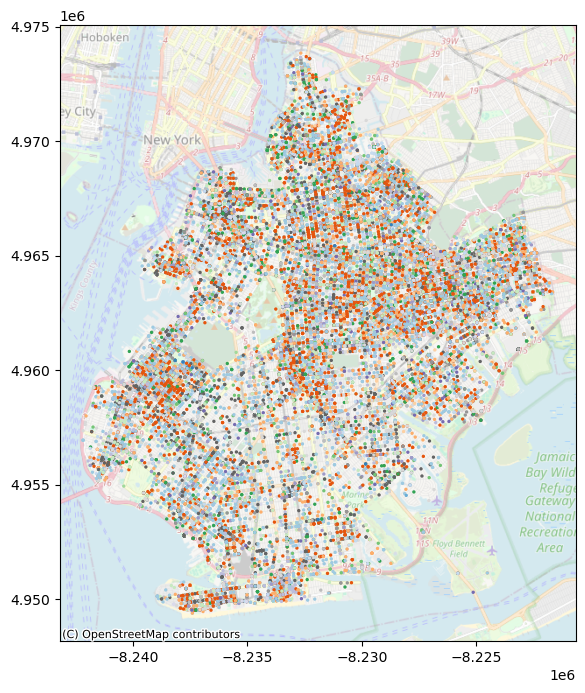

In [12]:
gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857) # in order to match the base map

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='OFNS_DESC', legend=False, markersize=2, categorical=True, cmap='tab20c', legend_kwds={'title': 'Description of Internal Classification'})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()

## Merge with Zipcode and Do Statistics

In [13]:
zipcode = gpd.read_file("../../data/processed_data/zipcode_bk.shp"); zipcode.head(3)

,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS,geometry
0,11213,Brooklyn,62426.0,2.963100e+07,36,047,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
1,11212,Brooklyn,83866.0,4.197210e+07,36,047,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
2,11225,Brooklyn,56527.0,2.369863e+07,36,047,"POLYGON ((995908.365 183617.613, 996522.848 18..."


In [14]:
zipcode_gdf = gpd.GeoDataFrame(zipcode, geometry=zipcode['geometry'], crs="EPSG:2263") # this is recorded in .prj file
gdf = gdf.to_crs(epsg=2263)
arrest_zipcode = gpd.sjoin(gdf, zipcode_gdf, how="left", op='intersects')
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,...,Longitude,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS
2,261336449,2023-01-04,ROBBERY,F,K,61,0,<18,M,BLACK,...,-73.960866,POINT (-73.960866 40.594054),POINT (995118.390 155708.848),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047
5,261583093,2023-01-08,FELONY ASSAULT,F,K,76,0,25-44,M,BLACK,...,-74.000504,POINT (-74.000504 40.683691),POINT (984110.183 188363.645),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047
7,261892107,2023-01-14,FELONY ASSAULT,F,K,90,0,25-44,M,BLACK,...,-73.955662,POINT (-73.955662 40.714082),POINT (996541.451 199439.144),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047


<Axes: >

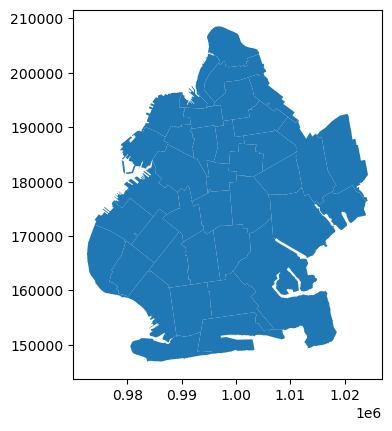

In [15]:
zipcode_gdf.plot()

In [16]:
zipcode_gdf.isnull().sum()

ZIPCODE       0
PO_NAME       0
POPULATION    0
AREA          0
ST_FIPS       0
CTY_FIPS      0
geometry      0
dtype: int64

In [17]:
crime_zipcode = arrest_zipcode.groupby('ZIPCODE').size().reset_index(name='counts')

In [18]:
combined_data = crime_zipcode.merge(zipcode, left_on='ZIPCODE', right_on='ZIPCODE', how ='outer')[['ZIPCODE', 'counts', 'geometry']]

In [19]:
gdf = gpd.GeoDataFrame(combined_data, geometry='geometry')

In [20]:
gdf = gdf.drop(29)

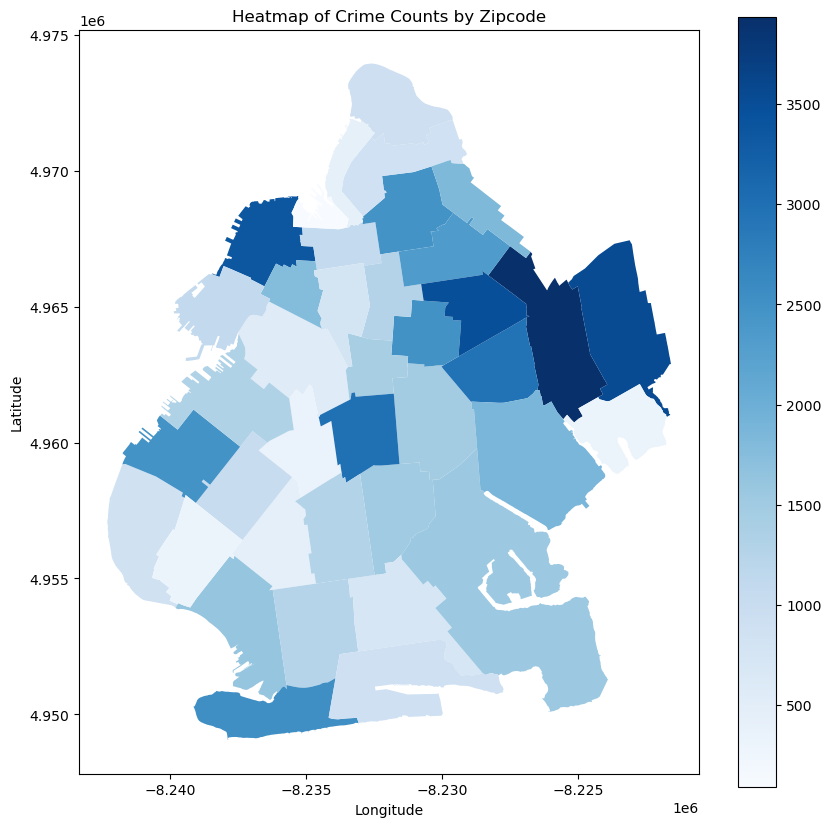

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf = gdf.to_crs(epsg=3857)

gdf.plot(column='counts', cmap='Blues', linewidth=1, ax=ax, legend=True)
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_title('Heatmap of Crime Counts by Zipcode')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('../../results/heatmap_crime.png')
plt.show()

In [22]:
gdf = gdf.to_crs(epsg=2263)

gdf['area_sq_mi'] = gdf['geometry'].area * 0.000000386102

gdf['density'] = gdf['counts'] / gdf['area_sq_mi']

gdf = gdf.to_crs(epsg=3857)

In [23]:
gdf

,ZIPCODE,counts,geometry,area_sq_mi,density
0,11201.0,3364,"POLYGON ((-8235269.841 4968992.031, -8235280.3...",15.866818,212.014784
1,11203.0,1479,"POLYGON ((-8231263.301 4962915.328, -8231132.9...",23.415092,63.164389
2,11204.0,464,"POLYGON ((-8235536.588 4958694.873, -8235521.9...",16.816744,27.591548
3,11205.0,1072,"POLYGON ((-8232449.552 4968095.504, -8232401.8...",8.984651,119.314597
4,11206.0,2467,"POLYGON ((-8230118.721 4969362.894, -8230107.4...",15.714630,156.987472
5,11207.0,3937,"POLYGON ((-8226920.128 4966791.233, -8226910.7...",28.558521,137.857277
6,11208.0,3541,"POLYGON ((-8222760.828 4965748.361, -8222758.3...",30.619311,115.645973
7,11209.0,863,"POLYGON ((-8241753.576 4959199.634, -8241746.2...",22.333033,38.642310
8,11210.0,1511,"POLYGON ((-8233011.389 4958846.952, -8232903.8...",18.489275,81.723052
9,11211.0,882,"POLYGON ((-8229426.081 4971328.469, -8229362.6...",15.625888,56.444791


In [24]:
gdf['density']

0     212.014784
1      63.164389
2      27.591548
3     119.314597
4     156.987472
5     137.857277
6     115.645973
7      38.642310
8      81.723052
9      56.444791
10    182.530473
11    217.646117
12     68.250716
13     23.338955
14    124.715145
15    213.079131
16     25.359819
17     62.957299
18    134.865176
19    157.089150
20     56.123608
21     55.238586
22    140.530060
23    155.080463
24    195.915564
25     18.410138
26     31.664394
27     66.712317
28     72.872790
30     60.903771
31    237.444949
32     19.481343
33     33.343571
34     50.281924
35    171.873508
36     69.173340
37     19.830201
38     62.956468
39     23.003134
Name: density, dtype: float64

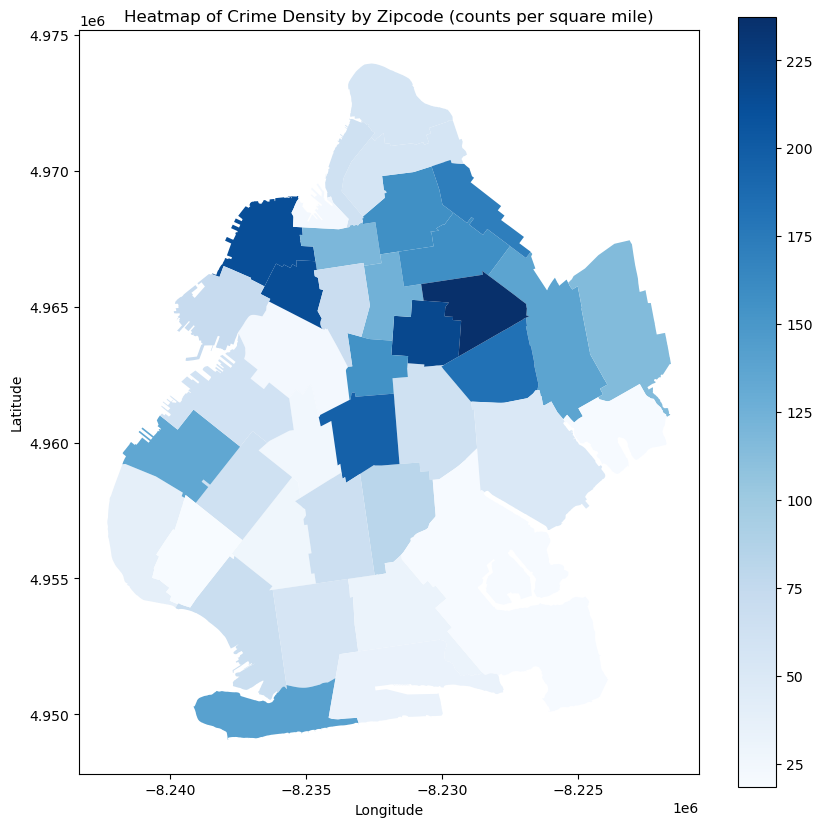

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf.plot(column='density', cmap='Blues', linewidth=1, ax=ax, legend=True)


#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_title('Heatmap of Crime Density by Zipcode (counts per square mile)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#ax.set_xticks([])
#ax.set_yticks([])

plt.savefig('../../results/heatmap_crime_density.png')

plt.show()

In [26]:
null_counts = arrest_zipcode.isnull().sum()
print(null_counts)

ARREST_KEY                    0
ARREST_DATE                   0
OFNS_DESC                     0
LAW_CAT_CD                    0
ARREST_BORO                   0
ARREST_PRECINCT               0
JURISDICTION_CODE             0
AGE_GROUP                     0
PERP_SEX                      0
PERP_RACE                     0
X_COORD_CD                    0
Y_COORD_CD                    0
Latitude                      0
Longitude                     0
New Georeferenced Column      0
geometry                      0
index_right                 657
ZIPCODE                     657
PO_NAME                     657
POPULATION                  657
AREA                        657
ST_FIPS                     657
CTY_FIPS                    657
dtype: int64


In [27]:
arrest_zipcode = arrest_zipcode[~arrest_zipcode.isnull().any(axis=1)]

In [28]:
column_chosen = []
for col in list(arrest_zipcode.columns):
    if len(arrest_zipcode[col].unique()) == 1:
        column_chosen.append(col)
        print(f'There is only 1 unique value in column {col}, which is {arrest_zipcode[col].unique()}')

There is only 1 unique value in column ARREST_BORO, which is ['K']
There is only 1 unique value in column PO_NAME, which is ['Brooklyn']
There is only 1 unique value in column ST_FIPS, which is ['36']
There is only 1 unique value in column CTY_FIPS, which is ['047']


In [29]:
arrest_zipcode = arrest_zipcode.drop('ARREST_BORO', axis=1)

### Calculate the Statisitcs

In [30]:
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,...,Longitude,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS
2,261336449,2023-01-04,ROBBERY,F,61,0,<18,M,BLACK,995118,...,-73.960866,POINT (-73.960866 40.594054),POINT (995118.390 155708.848),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047
5,261583093,2023-01-08,FELONY ASSAULT,F,76,0,25-44,M,BLACK,984110,...,-74.000504,POINT (-74.000504 40.683691),POINT (984110.183 188363.645),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047
7,261892107,2023-01-14,FELONY ASSAULT,F,90,0,25-44,M,BLACK,996541,...,-73.955662,POINT (-73.955662 40.714082),POINT (996541.451 199439.144),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047


In [31]:
arrest_zipcode['month'] = arrest_zipcode['ARREST_DATE'].dt.month

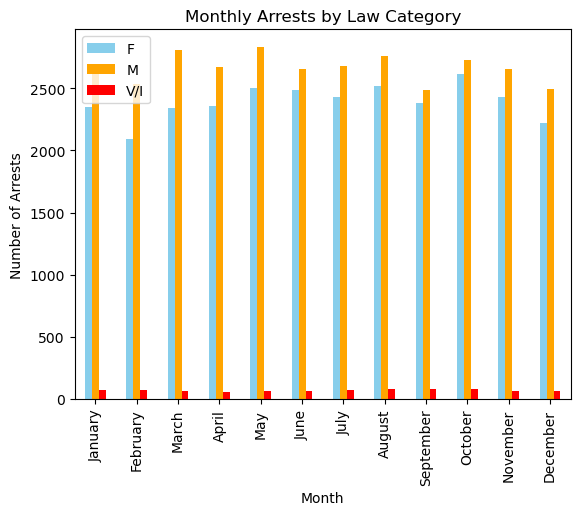

In [32]:
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
arrest_zipcode['month_name'] = arrest_zipcode['month'].map(month_names)

arrest_zipcode['month_name'] = pd.Categorical(arrest_zipcode['month_name'],
                                              categories=[month_names[i] for i in sorted(month_names)],
                                              ordered=True)

data_to_plot = arrest_zipcode.groupby(['month_name', 'LAW_CAT_CD']).size().unstack()

ax = data_to_plot.plot(kind='bar', color=['skyblue', 'orange', 'red'])


ax.set_title('Monthly Arrests by Law Category')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Arrests')
plt.xticks(rotation=90)
ax.legend(loc='best')

plt.savefig("../../results/monthly_arrest_by_law_cat.png")

plt.show()

In [33]:
arrest_zipcode.columns

Index(['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD',
       'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX',
       'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'New Georeferenced Column', 'geometry', 'index_right', 'ZIPCODE',
       'PO_NAME', 'POPULATION', 'AREA', 'ST_FIPS', 'CTY_FIPS', 'month',
       'month_name'],
      dtype='object')

In [34]:
arrest_zipcode['ZIPCODE'] = arrest_zipcode['ZIPCODE'].astype(int)

In [35]:
pd.crosstab(arrest_zipcode['ZIPCODE'], arrest_zipcode['month']).sum().sum()

61546

In [36]:
monthlyArrestCounts = pd.crosstab(arrest_zipcode['ZIPCODE'], arrest_zipcode['month'])
# rename the columns
monthlyArrestCounts.columns = [calendar.month_abbr[month] for month in monthlyArrestCounts.columns]
monthlyArrestCounts.columns = [f'{month}_ArrestCounts' for month in monthlyArrestCounts.columns]

In [37]:
summary = arrest_zipcode.groupby('ZIPCODE').agg(
    ArrestCount=pd.NamedAgg(column='ARREST_KEY', aggfunc='size'),
    population=pd.NamedAgg(column='POPULATION', aggfunc='mean'), 
    geometry=pd.NamedAgg(column='geometry', aggfunc='first')
)

summary = summary.join(monthlyArrestCounts, on='ZIPCODE')

In [38]:
summary.columns

Index(['ArrestCount', 'population', 'geometry', 'Jan_ArrestCounts',
       'Feb_ArrestCounts', 'Mar_ArrestCounts', 'Apr_ArrestCounts',
       'May_ArrestCounts', 'Jun_ArrestCounts', 'Jul_ArrestCounts',
       'Aug_ArrestCounts', 'Sep_ArrestCounts', 'Oct_ArrestCounts',
       'Nov_ArrestCounts', 'Dec_ArrestCounts'],
      dtype='object')

In [39]:
#summary.to_csv("../../data/processed_data/arrest_statistics.csv")

In [40]:
summary

,ArrestCount,population,geometry,Jan_ArrestCounts,Feb_ArrestCounts,Mar_ArrestCounts,Apr_ArrestCounts,May_ArrestCounts,Jun_ArrestCounts,Jul_ArrestCounts,Aug_ArrestCounts,Sep_ArrestCounts,Oct_ArrestCounts,Nov_ArrestCounts,Dec_ArrestCounts
ZIPCODE,,,,,,,,,,,,,,,
11201,3364,53041.0,POINT (989463.402 190450.368),271,263,291,273,340,279,277,289,276,260,289,256
11203,1479,78060.0,POINT (1002419.216 180820.847),118,128,124,112,148,131,124,147,112,120,124,91
11204,464,77354.0,POINT (988176.018 163892.114),19,32,33,40,49,45,37,44,41,31,57,36
11205,1072,41125.0,POINT (991150.338 192509.621),101,84,97,72,97,75,74,110,98,94,96,74
11206,2467,83575.0,POINT (1002439.519 198129.443),219,170,221,201,207,209,254,187,183,233,206,177
11207,3937,93556.0,POINT (1013654.512 177162.351),317,315,384,315,360,370,325,329,273,315,342,292
11208,3541,94410.0,POINT (1017119.395 183909.431),269,263,270,282,334,308,279,337,308,327,301,263
11209,863,69255.0,POINT (976380.014 166180.097),91,71,97,61,69,73,60,67,53,50,84,87
11210,1511,67067.0,POINT (1000520.547 168264.388),117,105,115,111,102,150,132,133,130,144,158,114


In [41]:
summary.shape

(39, 15)